### TRABAJO  4  FdA PREDICCIÓN DE CANTIDAD DE CARROS REGISTRADOS EN EL RUNT

In [34]:
#Importar librerias
import pandas as pd
import numpy as np 
from datetime import datetime, date
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import holidays
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.cluster import KMeans
from unidecode import unidecode
import re
import warnings

# Ignore FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

In [35]:
#Establecer estilo de los graficos
sns.set(style="darkgrid", palette="Set2",)

# Ignorar advertencias de tipo FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

El RUNT es un sistema que permite registrar y mantener actualizada, centralizada, autorizada y validada la información de registros de automóviles, conductores, accidentes de transito y demás. Actualmente se cuenta con un conjunto de datos del RUNT que permite conocer el número de vehículos registrados diariamente en un periodo de tiempo comprendido entre el 2012 y el 2017. Sin embargo, la información a partir del año 2017 se desconoce y se sabe que es valiosa puesto que podría servir para optimizar los procesos dentro del tránsito o el ministerio de transporte, estando así preparados para días o meses en los que se presenten una gran cantidad de registros. Teniendo en cuenta esta problemática, queremos hacer un modelo predictivo que va a ser evaluado según los criterios del R2 que demuestra que tanto fit tiene el modelo con los datos.

In [36]:
#Importacion del dataset
df = pd.read_excel('registros_autos_entrenamiento.xlsx')
df.head()

,Fecha,Unidades
0,2012-01-01,0
1,2012-01-02,188
2,2012-01-03,482
3,2012-01-04,927
4,2012-01-05,1159


Primero vamos a revisar como se presentan los datos, si encontramos NaN o datos repetidos

In [37]:
df.shape

(2192, 2)

In [38]:
df.isnull().sum()

Fecha       0
Unidades    0
dtype: int64

In [39]:
df[df.duplicated()]

,Fecha,Unidades


No se encontro ninguna anomalia asi que continuamos con graficas descriptivas

In [40]:
df.dtypes

Fecha       datetime64[ns]
Unidades             int64
dtype: object

Haremos una grafica de series de tiempo para ver como se comportan los datos con el paso del tiempo

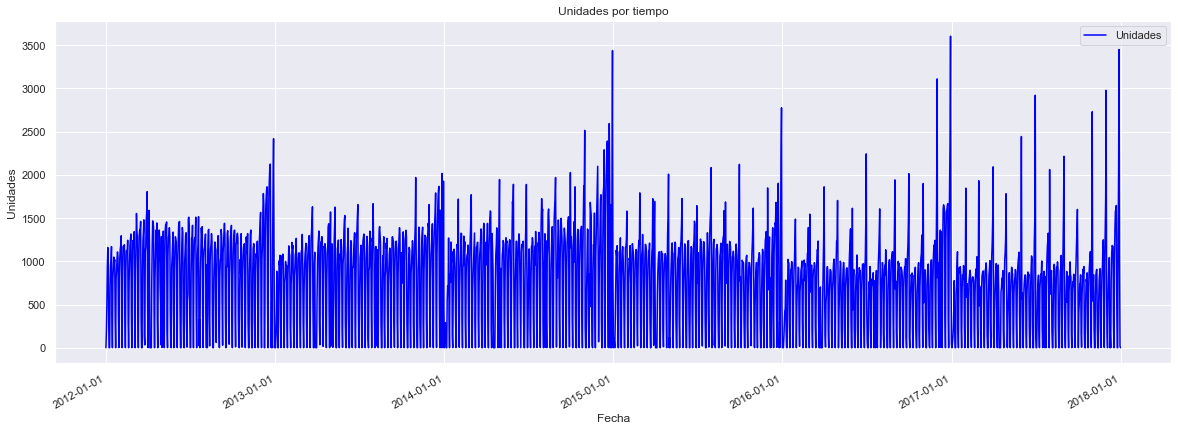

In [41]:
x=np.array(df['Fecha'])
y=np.array(df['Unidades'])
plt.figure(figsize=(20, 7))  # Optional: Set the figure size
plt.plot(x, y, marker=None, linestyle='-', color='b', label='Unidades')

# Optional: Add labels and title
plt.xlabel('Fecha')
plt.ylabel('Unidades')
plt.title('Unidades por tiempo')

# Optional: Customize the x-axis date formatting
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()  # Rotates and formats the x-axis dates for better readability

# Optional: Add a legend
plt.legend()

# Show the plot
plt.show()

Se puede denotar como cada año el pico de registro se concentra cerca a finales del mismo, en las epocas de invierno (en especial diciembre con los mayores picos) pero también se ve como con el paso del tiempo los registro pasan de ser más balanceados y se genera picos mas seguido generando una mayor varianza.

In [42]:
df['Unidades'].describe()

count    2192.000000
mean      782.165602
std       551.164725
min         0.000000
25%       293.000000
50%       865.500000
75%      1173.000000
max      3603.000000
Name: Unidades, dtype: float64

También se puede ver como al frecuencia de registros se encuentra en valores entre 0 a 500 y entre 800 a 1500, y ya luego como casi no se supera los 2000 registros en un dia

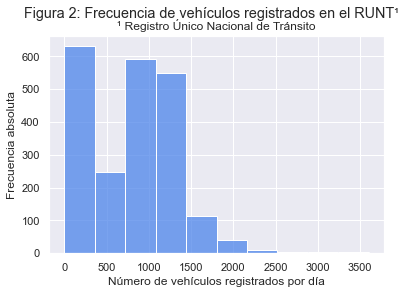

In [43]:
sns.histplot(data=df, x='Unidades', bins=10, color='#4d85ea')
plt.title("¹ Registro Único Nacional de Tránsito")
plt.xlabel("Número de vehículos registrados por día")
plt.ylabel("Frecuencia absoluta")
plt.suptitle("Figura 2: Frecuencia de vehículos registrados en el RUNT¹")
plt.show()

Procedemos entonces a generar variables para usar en el modelo predictivo derivadas de la fecha

In [44]:
df['Dia'] = df['Fecha'].dt.day
df['Mes'] = df['Fecha'].dt.month
df['Año'] = df['Fecha'].dt.year

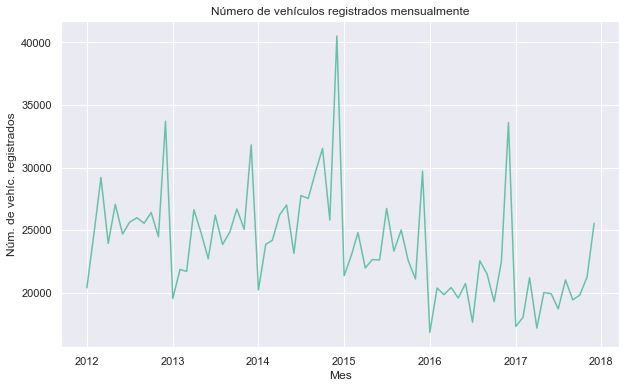

In [45]:
dbMesano = df.groupby(['Año', 'Mes'])['Unidades'].sum().reset_index()

# Create a new column 'Mes' by concatenating 'mes' and 'anno', then format it as a date
dbMesano['Mes'] = pd.to_datetime(dbMesano['Mes'].astype(str) + '-' + dbMesano['Año'].astype(str), format='%m-%Y')

# Create a time series using the 'Mes' column as the index
tseries = pd.Series(dbMesano['Unidades'].values, index=dbMesano['Mes'])

# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(tseries)
plt.title('Número de vehículos registrados mensualmente')
plt.xlabel('Mes')
plt.ylabel('Núm. de vehíc. registrados')
plt.show()

In [46]:
df.head(-10)

,Fecha,Unidades,Dia,Mes,Año
0,2012-01-01,0,1,1,2012
1,2012-01-02,188,2,1,2012
2,2012-01-03,482,3,1,2012
3,2012-01-04,927,4,1,2012
4,2012-01-05,1159,5,1,2012
...,...,...,...,...,...
2177,2017-12-17,0,17,12,2017
2178,2017-12-18,959,18,12,2017
2179,2017-12-19,1364,19,12,2017
2180,2017-12-20,1577,20,12,2017


Ahora generamos las fechas especiales como festivos,dias de la semana y que dias son laborales para tener una mejor diferenciación en los datos

In [47]:

festivos = holidays.country_holidays('CO', years=[2012, 2013, 2014, 2015, 2016, 2017])
def es_festivo(fecha):
    return 1 if fecha.date() in festivos else 0

# Crear la columna 'Festivo' en función de la función es_festivo
df['Festivo'] = df['Fecha'].apply(es_festivo)
df['Dia_Semana'] = df['Fecha'].dt.dayofweek
df['Semana_Año'] = df['Fecha'].dt.isocalendar().week

def determinar_quincena(fecha):
    return np.where(fecha.dt.day <= 15, 1, 2)
df['Quincena'] = determinar_quincena(df['Fecha'])



In [48]:
condicion_dias_laborales = (df['Dia_Semana'] != 6) & (df['Festivo'] != 1)
df['dias_laborales'] = condicion_dias_laborales.astype(int)

In [49]:
data=df

Separamos los datos en un set de 2017 que luego sera usado para validación y otro que va del 2012 al 2016 que es usado para entrenamiento

In [50]:
data2017=data[data['Año'] ==2017]
data=data[data['Año'] < 2017]

In [51]:
data.head()

,Fecha,Unidades,Dia,Mes,Año,Festivo,Dia_Semana,Semana_Año,Quincena,dias_laborales
0,2012-01-01,0,1,1,2012,1,6,52,1,0
1,2012-01-02,188,2,1,2012,0,0,1,1,1
2,2012-01-03,482,3,1,2012,0,1,1,1,1
3,2012-01-04,927,4,1,2012,0,2,1,1,1
4,2012-01-05,1159,5,1,2012,0,3,1,1,1


Seleccionamos las columnas a usar para x

In [52]:
columnas_seleccionadas = ['Dia','Mes','Año', 'Festivo','Dia_Semana','dias_laborales']
datanew=data[columnas_seleccionadas]

Generamos un database donde luego se guardaran los valores predecidos

In [53]:
datacsv=data.drop('Unidades',axis=1)

Empezaremos con una regresión linear simple

Mean Squared Error (MSE): 106379.70296138372
R^2 Score: 0.6394565957966514
Mean Absolute Error (MAE): 255.7172514480096


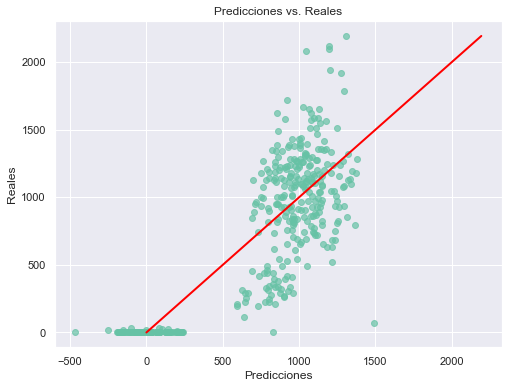

In [54]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# Supongamos que 'data' es tu DataFrame con columnas 'feature' y 'target'
# Asegúrate de tener tus datos limpios y de haber tratado los valores nulos

# Dividir el conjunto de datos en características (X) y variable objetivo (y)
X = datanew
y = data['Unidades']

# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear un modelo de regresión lineal
modellr = LinearRegression()

# Entrenar el modelo con el conjunto de entrenamiento
modellr.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = modellr.predict(X_test)

# Evaluar el rendimiento del modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'R^2 Score: {r2}')
print(f'Mean Absolute Error (MAE): {mae}')

# Visualizar el modelo
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, y_test, alpha=0.7)
plt.xlabel("Predicciones")
plt.ylabel("Reales")
plt.title("Predicciones vs. Reales")

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linewidth=2)


Podemos ver que este modelo no es el mejor asi que vamos a explorar otras opciones

## RandomForest

Mean Squared Error (MSE): 19962.842998421373
R^2 Score: 0.9323416857552184
Mean Absolute Error (MAE): 90.22765027322404


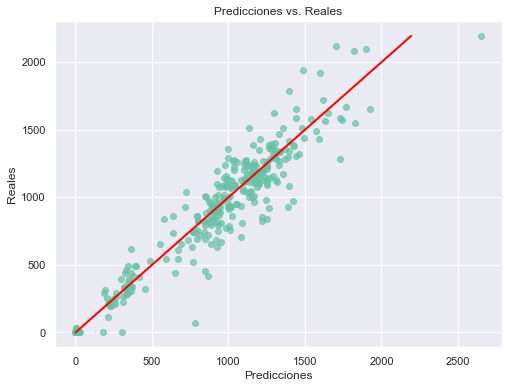

In [55]:

from sklearn.ensemble import RandomForestRegressor
from xgboost import plot_importance
X = datanew
y = data['Unidades']

# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear un modelo de regresión de bosques aleatorios
modelrf = RandomForestRegressor(random_state=42,n_estimators=75)

# Entrenar el modelo con el conjunto de entrenamiento
modelrf.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = modelrf.predict(X_test)

# Evaluar el rendimiento del modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'R^2 Score: {r2}')
print(f'Mean Absolute Error (MAE): {mae}')

# Visualizar el modelo
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, y_test, alpha=0.7)
plt.xlabel("Predicciones")
plt.ylabel("Reales")
plt.title("Predicciones vs. Reales")

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linewidth=2)
plt.show()



Este dio muchos mejores resultados

## KNN vecinos más cercanos

Mean Squared Error (MSE): 48899.93832943012
R^2 Score: 0.8342677245768724
Mean Absolute Error (MAE): 146.3231850117096


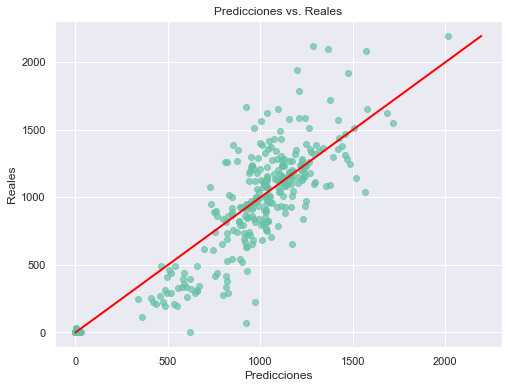

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# Supongamos que ya tienes tus datos X e y

# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Aplicar preprocesamiento (escalar las características)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crear un modelo de regresión KNN
knn_model = KNeighborsRegressor(n_neighbors=7)  # Puedes ajustar el valor de 'n_neighbors'

# Entrenar el modelo con el conjunto de entrenamiento escalado
knn_model.fit(X_train_scaled, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = knn_model.predict(X_test_scaled)

# Evaluar el rendimiento del modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'R^2 Score: {r2}')
print(f'Mean Absolute Error (MAE): {mae}')

# Visualizar el modelo
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, y_test, alpha=0.7)
plt.xlabel("Predicciones")
plt.ylabel("Reales")
plt.title("Predicciones vs. Reales")

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linewidth=2)
plt.show()


Aunque los resultados no fueron tan malos como la regresión lineal no fueron mejores que el randomforest

## XGBModel

Mean Squared Error (MSE): 17235.976453139112
R^2 Score: 0.9415836155564435
Mean Absolute Error (MAE): 91.0918688852279


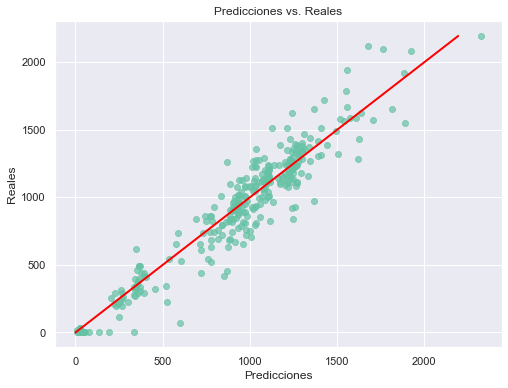

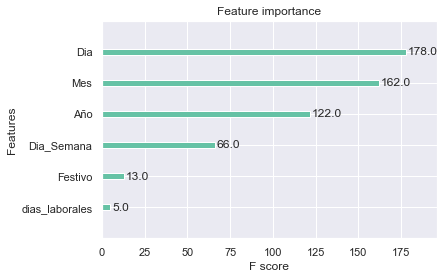

In [57]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# Supongamos que ya tienes tus datos X e y

# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear un modelo de regresión XGBoost
modelxgb = XGBRegressor(random_state=43,
                            n_estimators=10,
                            max_depth=7)

# Entrenar el modelo con el conjunto de entrenamiento
modelxgb.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = modelxgb.predict(X_test)

# Evaluar el rendimiento del modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'R^2 Score: {r2}')
print(f'Mean Absolute Error (MAE): {mae}')

# Visualizar el modelo
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, y_test, alpha=0.7)
plt.xlabel("Predicciones")
plt.ylabel("Reales")
plt.title("Predicciones vs. Reales")

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linewidth=2)
plt.show()

plot_importance(modelxgb)
plt.show()


Este fue el que mejores resultados dio y a la vez tiene la ventaja de permitirnos ver cuales variables fueron más importantes en la predicción

## Predicción 2018

Ahora crearemos los datos necesarios para tener una DF para poder usar para generar la predicción y consecuentemente guardar estas misma predicciones dentro

In [58]:
start_date = datetime(2018, 1, 1)
end_date = datetime(2018, 12, 31)

# Crear un rango de fechas
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Crear un DataFrame con las fechas
df2018 = pd.DataFrame(date_range, columns=['Fecha'])
df2018['Dia'] = df2018['Fecha'].dt.day
df2018['Mes'] = df2018['Fecha'].dt.month
df2018['Año'] = df2018['Fecha'].dt.year
df2018['Festivo'] = df2018['Fecha'].apply(es_festivo)
df2018['Dia_Semana'] = df2018['Fecha'].dt.dayofweek
df2018['Semana_Año'] = df2018['Fecha'].dt.isocalendar().week
condicion_dias_laborales = (df2018['Dia_Semana'] != 6) & (df2018['Festivo'] != 1)
df2018['dias_laborales'] = condicion_dias_laborales.astype(int)
df2018['Quincena'] = determinar_quincena(df2018['Fecha'])
data2018=df2018
print(data2018)


         Fecha  Dia  Mes   Año  Festivo  Dia_Semana  Semana_Año  \
0   2018-01-01    1    1  2018        1           0           1   
1   2018-01-02    2    1  2018        0           1           1   
2   2018-01-03    3    1  2018        0           2           1   
3   2018-01-04    4    1  2018        0           3           1   
4   2018-01-05    5    1  2018        0           4           1   
..         ...  ...  ...   ...      ...         ...         ...   
360 2018-12-27   27   12  2018        0           3          52   
361 2018-12-28   28   12  2018        0           4          52   
362 2018-12-29   29   12  2018        0           5          52   
363 2018-12-30   30   12  2018        0           6          52   
364 2018-12-31   31   12  2018        0           0           1   

     dias_laborales  Quincena  
0                 0         1  
1                 1         1  
2                 1         1  
3                 1         1  
4                 1         1  
.. 

In [59]:
data2017x=data2017[columnas_seleccionadas]
data2017y=data2017['Unidades']
data2017graph=data2017.drop('Unidades',axis=1)



In [60]:
data2017x.head()

,Dia,Mes,Año,Festivo,Dia_Semana,dias_laborales
1827,1,1,2017,1,6,0
1828,2,1,2017,0,0,1
1829,3,1,2017,0,1,1
1830,4,1,2017,0,2,1
1831,5,1,2017,0,3,1


Veremos como funciona el modelo ya entrenado prediciendo los datos del 2017

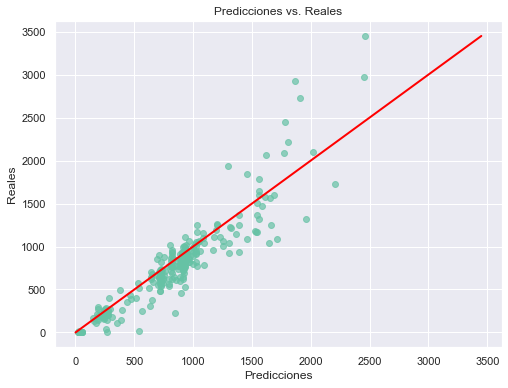

31665.88271748328
0.8865797083831292


In [61]:

y_pred2=modelxgb.predict(data2017x)


mse2=mean_squared_error(data2017y,y_pred2)


mae2=mean_absolute_error(data2017y,y_pred2)

r2v=r2_score(data2017y,y_pred2)


plt.figure(figsize=(8, 6))
plt.scatter(y_pred2, data2017y, alpha=0.7)
plt.xlabel("Predicciones")
plt.ylabel("Reales")
plt.title("Predicciones vs. Reales")

plt.plot([min(data2017y), max(data2017y)], [min(data2017y), max(data2017y)], color="red", linewidth=2)
plt.show()

print(mse2)


print(r2v)


Ahora generaremos la predicciones del 2018 y las guardaremos en el DF previamente creado

In [62]:

data2018x=data2018[columnas_seleccionadas]
ypred2018=modelxgb.predict(data2018x)
ypred_df = pd.DataFrame({'Unidades predecidas': ypred2018})
pred2018=pd.merge(data2018, ypred_df, left_index=True, right_index=True)
pred2018.head()

,Fecha,Dia,Mes,Año,Festivo,Dia_Semana,Semana_Año,dias_laborales,Quincena,Unidades predecidas
0,2018-01-01,1,1,2018,1,0,1,0,1,18.647535
1,2018-01-02,2,1,2018,0,1,1,1,1,352.780182
2,2018-01-03,3,1,2018,0,2,1,1,1,748.735413
3,2018-01-04,4,1,2018,0,3,1,1,1,861.556946
4,2018-01-05,5,1,2018,0,4,1,1,1,899.979065


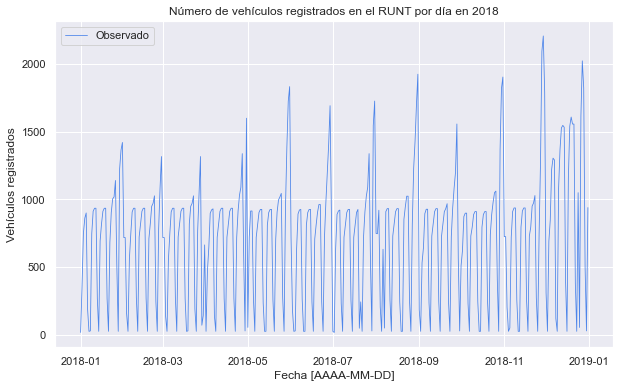

In [65]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(pred2018['Fecha'], pred2018['Unidades predecidas'], label='Observado', linewidth=0.8, color='#4d85ea')

plt.title('Número de vehículos registrados en el RUNT por día en 2018')
plt.xlabel('Fecha [AAAA-MM-DD]')
plt.ylabel('Vehículos registrados')
plt.legend()
plt.show()

Haremos los mismo con las predicciones del 2012 al 2016 para poder volverlos archivos planos

In [69]:
ypredcsv=modelxgb.predict(X)
ypred_df_1216=pd.DataFrame({'Unidades predecidas': ypredcsv})
pred2012_16=pd.merge(data, ypred_df_1216, left_index=True, right_index=True)
pred2012_16.head()

,Fecha,Unidades,Dia,Mes,Año,Festivo,Dia_Semana,Semana_Año,Quincena,dias_laborales,Unidades predecidas
0,2012-01-01,0,1,1,2012,1,6,52,1,0,26.706736
1,2012-01-02,188,2,1,2012,0,0,1,1,1,302.870544
2,2012-01-03,482,3,1,2012,0,1,1,1,1,538.175171
3,2012-01-04,927,4,1,2012,0,2,1,1,1,975.132507
4,2012-01-05,1159,5,1,2012,0,3,1,1,1,1032.524536


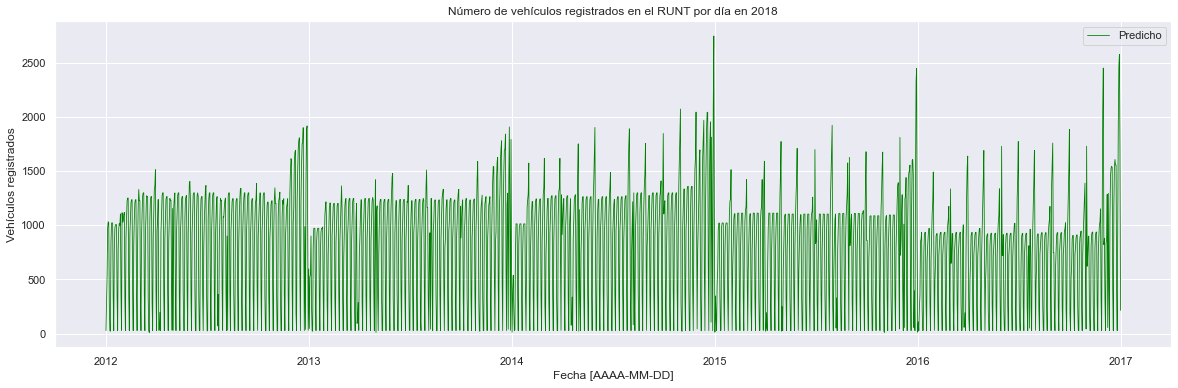

In [78]:
plt.figure(figsize=(20, 6))

plt.plot(pred2012_16['Fecha'], pred2012_16['Unidades predecidas'], label='Predicho', linewidth=0.8, color='#008000')

plt.title('Número de vehículos registrados en el RUNT por día en 2018')
plt.xlabel('Fecha [AAAA-MM-DD]')
plt.ylabel('Vehículos registrados')
plt.legend()
plt.show()

Y por ultimo generaremos los archivos planos

In [ ]:
#Guardar el dataset procesado
#pred2018.to_csv('prediccion_2018.csv', sep=',', encoding='utf-8', index=False)


In [ ]:
#pred2012_16.to_csv('prediccion_2012-16.csv', sep=',', encoding='utf-8', index=False)